In [23]:
import scienceplots

import matplotlib.pyplot as plt

from ocpaper231.names import variable_manager as vm

plt.style.use(("science", "notebook"))

import importlib
import gnn_tracking.metrics.cluster_metrics
importlib.reload(gnn_tracking.metrics.cluster_metrics)

<module 'gnn_tracking.metrics.cluster_metrics' from '/home/kl5675/Documents/23/git_sync/gnn_tracking/src/gnn_tracking/metrics/cluster_metrics.py'>

In [29]:
from gnn_tracking.utils.loading import TrackingDataModule

dm = TrackingDataModule(
    train=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8_cut/part_1/"
        ],
    ),
    val=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8_cut/part_1/"
        ],
        stop=100,
    ),
)
dm.setup(stage="fit")

[00:44:29] INFO: DataLoader will load 719 graphs (out of 719 available).
[00:44:29] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8_cut/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8_cut/part_1/data21999_s0.pt
[00:44:29] INFO: DataLoader will load 100 graphs (out of 719 available).
[00:44:29] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8_cut/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8_cut/part_1/data21118_s0.pt


In [30]:
n_edges = 0
n_true = 0
for data in dm.val_dataloader():
    n_edges += data.edge_index.shape[1]
    n_true += data.y.sum()
print(n_edges / len(dm.datasets["val"]))
print(n_true / n_edges)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


89361.71
tensor(0.6785)


In [27]:
0.045 * 2.8

0.126

In [3]:
from gnn_tracking.metrics.cluster_metrics import tracking_metrics_data, \
    tracking_metric_df
from gnn_tracking.analysis.graphs import get_cc_labels
import pandas as pd


def get_truth_hc_dfs(dm):
    h_dfs = []
    c_dfs = []
    for data in dm.val_dataloader():
        y = data.y.bool()
        ei = data.edge_index[:, y]
        labels = get_cc_labels(ei, num_nodes=data.num_nodes)
        h_df = pd.DataFrame(
                {
                "c": labels,
                "id": data.particle_id,
                "pt": data.pt,
                "reconstructable": data.reconstructable,
                "eta": data.eta,
            }
        )
        c_df = tracking_metric_df(h_df)
        h_dfs.append(h_df)
        c_dfs.append(c_df)
    return h_dfs, c_dfs

In [4]:
from gnn_tracking.metrics.cluster_metrics import tracking_metrics_vs_pt


h_dfs, c_dfs = get_truth_hc_dfs(dm)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


In [16]:
from gnn_tracking.metrics.cluster_metrics import tracking_metrics_vs_eta
import numpy as np

etas = np.array(np.linspace(-4, 4, 8*2+1).tolist() + [4.0])
etas

array([-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,
        1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4. ])

In [17]:
vs_eta_ul = tracking_metrics_vs_eta(h_dfs, c_dfs, etas=etas)

In [18]:
from ocpaper231.plotutils import Plot


class PerformancePlot(Plot):
    def __init__(self, xs, df, *, df_ul=None, var="pt", **kwargs):
        super().__init__(**kwargs)
        self.df = df
        self.df_ul = df_ul
        self.xs = xs
        self.ax.set_xlabel(var)
        self.ax.set_ylabel("Efficiency")

    def plot_var(
        self,
        var,
        color,
        *,
        label=None,
        plot_ul=True,
    ):
        self.ax.stairs(var, edges=self.xs, data=self.df, color=color, lw=1.5, label=label)
        if self.df_ul is not None and plot_ul:
            self.ax.stairs(var, edges=self.xs, data=self.df_ul, color=color, lw=1.5, ls=":")
        mids = (self.xs[:-1] + self.xs[1:]) / 2
        # self.ax.errorbar(
        #     mids,
        #     var,
        #     yerr=f"{var}_std",
        #     ls="none",
        #     color=color,
        #     label=label,
        #     data=self.df,
        # )

    def add_blocked(self, a, b, label="Not trained for"):
        self.ax.axvspan(a, b, alpha=0.3, color="gray", label=label, linestyle="none")

In [19]:
vs_eta_ul.to_csv("vs_eta_gc.csv")

In [20]:
!pwd

/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/legacy


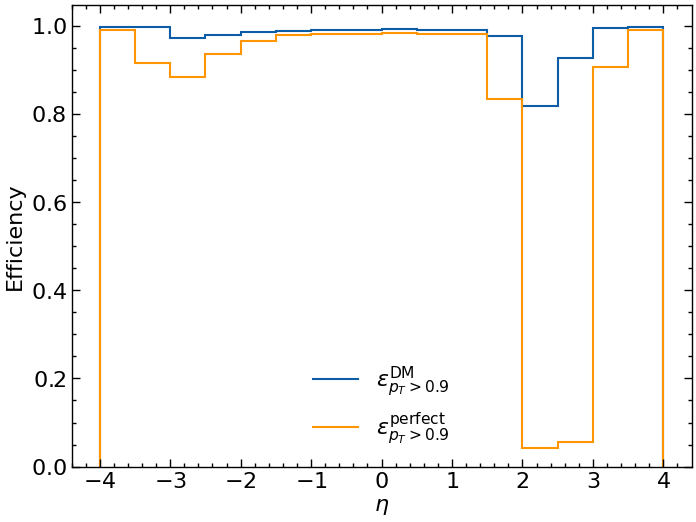

In [21]:
p = PerformancePlot(df=vs_eta_ul, xs=etas, var=vm["eta"].latex)  # , model=model)
p.plot_var("double_majority", "C0", label=vm["double_majority_pt0.9"].latex)
p.plot_var("perfect", "C2", label=vm["perfect_pt0.9"].latex)
p.ax.legend()

In [17]:
data = dm.datasets["val"][0]
dc = data # data.subgraph((data.eta > 2))

In [18]:
y_no_intersect = (dc.particle_id[dc.edge_index[0]] == dc.particle_id[dc.edge_index[1]]) & (dc.particle_id[dc.edge_index[0]] > 0)

In [19]:
y_no_intersect.sum()

tensor(142156)

In [20]:
dc.y.sum()

tensor(124832.)

In [21]:
from gnn_tracking.analysis.graphs import get_largest_segment_fracs
import torch
dc.y = torch.ones_like(dc.y, dtype=torch.long)
lsf = get_largest_segment_fracs(dc, )

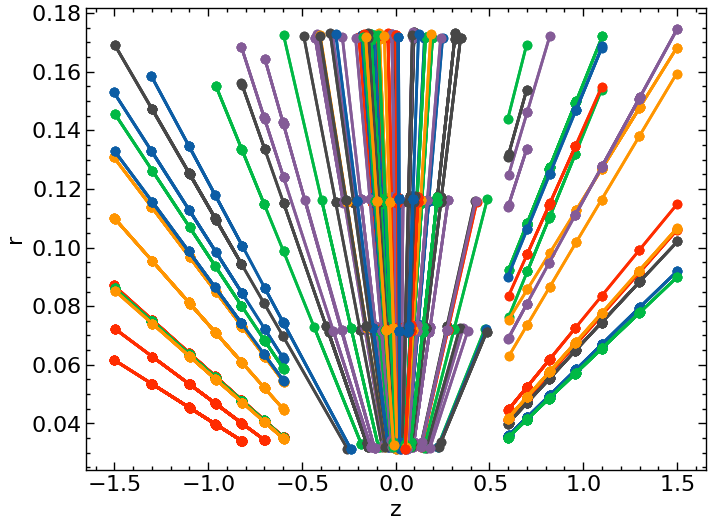

In [24]:
fig, ax = plt.subplots()
ax.set_xlabel("z")
ax.set_ylabel("r")
pids = torch.unique(dc.particle_id)[-100:]
# ax.set_title("2 < eta")
for i, pid in enumerate(pids):
    color = f"C{i % 6}"
    edge_mask = (dc.particle_id[dc.edge_index[0]] == pid) &  (dc.particle_id[dc.edge_index[1]] == pid)
    ei = dc.edge_index[:, edge_mask]
    start_rs = dc.x[:,0][ei[0]]
    start_zs = dc.x[:,2][ei[0]]
    end_rs = dc.x[:,0][ei[1]]
    end_zs = dc.x[:,2][ei[1]]
    for i in range(len(start_rs)):
        ax.plot((start_zs[i], end_zs[i]), (start_rs[i], end_rs[i]), c=color, marker="o")

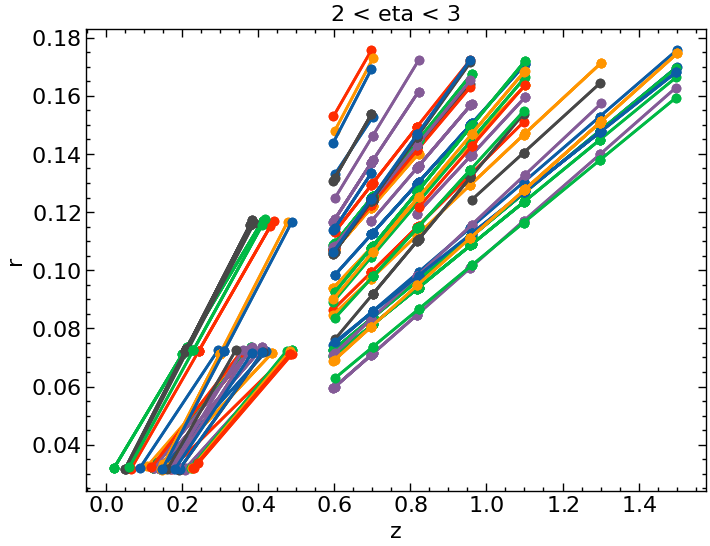

In [110]:
ax.get_figure()

In [172]:
import logging
import os
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from numpy import ndarray as A
from pandas import DataFrame as DF
from torch_geometric.data import Data
from tqdm import tqdm

from gnn_tracking.preprocessing.point_cloud_builder import DEFAULT_FEATURES
from gnn_tracking.utils.log import get_logger, logger

class GraphBuilder:
    def __init__(
        self,
        pixel_only=True,
        phi_slope_max=0.001825,
        z0_max=197.4,
        dR_max=1.797,
        remove_intersecting=True,
        directed=False,
        measurement_mode=False,
        log_level=0,
    ):

        self.pixel_only = pixel_only
        self.phi_slope_max = phi_slope_max
        self.z0_max = z0_max
        self.dR_max = dR_max
        #: Name/meaning of the node features
        self.feature_names = DEFAULT_FEATURES
        self.directed = directed
        self.measurement_mode = measurement_mode
        self.measurements = []
        level = logging.DEBUG if log_level > 0 else logging.INFO
        self.logger = get_logger("GraphBuilder", level)
        self._remove_intersecting = remove_intersecting

    def calc_dphi(self, phi1: np.ndarray, phi2: np.ndarray) -> np.ndarray:
        """Computes phi2-phi1 given in range [-pi,pi]"""
        dphi = phi2 - phi1
        dphi[dphi > np.pi] -= 2 * np.pi
        dphi[dphi < -np.pi] += 2 * np.pi
        return dphi

    def calc_eta(self, r: np.ndarray, z: np.ndarray) -> np.ndarray:
        """Computes pseudorapidity
        (https://en.wikipedia.org/wiki/Pseudorapidity)
        """
        theta = np.arctan2(r, z)
        return -1.0 * np.log(np.tan(theta / 2.0))

    def get_dataframe(self, evt: Data, evtid: int) -> DF:
        """Converts pytorch geometric data object to pandas dataframe

        Args:
            evt: pytorch geometric data object
            evtid: event id

        Returns:
            pandas dataframe
        """
        to_df = {"evtid": evtid}
        for i, n in enumerate(self.feature_names):
            to_df[n] = evt.x[:, i]
        to_df["layer"] = evt.layer
        to_df["pt"] = evt.pt
        to_df["particle_id"] = evt.particle_id
        return pd.DataFrame(to_df)

    def select_edges(self, hits1: DF, hits2: DF, layer1: int, layer2: int) -> DF:
        hit_pairs = hits1.reset_index().merge(
            hits2.reset_index(), on="evtid", suffixes=("_1", "_2")
        )

        # define various geometric quantities
        dphi = self.calc_dphi(hit_pairs.phi_1, hit_pairs.phi_2)
        dz = hit_pairs.z_2 - hit_pairs.z_1
        dr = hit_pairs.r_2 - hit_pairs.r_1
        eta_1 = self.calc_eta(hit_pairs.r_1, hit_pairs.z_1)
        eta_2 = self.calc_eta(hit_pairs.r_2, hit_pairs.z_2)
        deta = eta_2 - eta_1
        dR = np.sqrt(deta**2 + dphi**2)

        # restrict phi_slope and z0
        phi_slope = dphi / dr
        z0 = hit_pairs.z_1 - hit_pairs.r_1 * dz / dr

        # apply the intersecting line cut
        if (layer1 == 0) and (layer2 in [4, 11]):
            # 0th barrel layer to left EC or right EC
            # We calculate the z coordinate that the edge passes through when it is on
            # the r height of layer 1. We check if it is between the z range of layer
            # 1 to see if the edge intersects layer 1
            layer_1_r = 71.56298065185547
            z_coord = layer_1_r * dz / dr + z0
            intersected_layer = np.logical_and(z_coord > -490.975, z_coord < 490.975)
        elif (layer1 == 1) and (layer2 in [4, 11]):
            # 1st barrel layer to the left EC or right EC
            layer_2_r = 115.37811279296875
            z_coord = layer_2_r * dz / dr + z0
            intersected_layer = np.logical_and(z_coord > -490.975, z_coord < 490.975)
        else:
            intersected_layer = dr.abs() < -1

        # filter edges according to selection criteria
        # if self._remove_intersecting:
        #     good_edge_mask &= ~intersected_layer

        # store edges (in COO format) and geometric edge features
        return pd.DataFrame(
            {
                "index_1": hit_pairs["index_1"],
                "index_2": hit_pairs["index_2"],
                "dr": dr,
                "dphi": dphi,
                "dz": dz,
                "dR": dR,
                "intersected": intersected_layer,
                "phi_slope_mask": phi_slope.abs() < self.phi_slope_max,
                "z0_mask": z0.abs() < self.z0_max,
                "dR_mask": dR < self.dR_max,
                "layer1": layer1,
                "layer2": layer2,
                "r_1": hit_pairs.r_1,
                "r_2": hit_pairs.r_2,
                "z_1": hit_pairs.z_1,
                "z_2": hit_pairs.z_2,

            }
        )


    def build_edges(self, hits: DF) -> tuple[A, A, A, A]:
        """Build edges between hits

        Args:
            hits: Point cloud dataframe

        Returns:
            edge_index (2 x num edges), edge_attr (edge features x num edges),
            y (truth label, shape = num edges), edge_pt (pt of track belong to first
            hit)
        """
        if self.pixel_only:
            layer_pairs = [
                (0, 1),
                (1, 2),
                (2, 3),  # barrel-barrel
                (0, 4),
                (1, 4),
                (2, 4),
                (3, 4),  # barrel-LEC
                (0, 11),
                (1, 11),
                (2, 11),
                (3, 11),  # barrel-REC
                (4, 5),
                (5, 6),
                (6, 7),
                (7, 8),
                (8, 9),
                (9, 10),  # LEC-LEC
                (11, 12),
                (12, 13),
                (13, 14),
                (14, 15),
                (15, 16),
                (16, 17),  # REC-REC
            ]
        else:
            layer_pairs = []

        groups = hits.groupby("layer")
        edges = []
        for layer1, layer2 in layer_pairs:
            try:
                hits1 = groups.get_group(layer1)
                hits2 = groups.get_group(layer2)
            except KeyError:
                continue

            edges_layer_pair = self.select_edges(
                hits1,
                hits2,
                layer1,
                layer2,
            )
            edges.append(edges_layer_pair)
        return pd.concat(edges)

    def process(self, data):
        """Main processing loop

        Args:
            start:
            stop:
            only_sector: Only process files for this sector. If < 0 (default): process
                all sectors.

        Returns:

        """
        df = self.get_dataframe(data, 0)
        return self.build_edges(df)



In [173]:
gb = GraphBuilder()

In [174]:
pc = torch.load("/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_1/data21000_s0.pt")

In [175]:
pids = torch.unique(pc.particle_id)[:500]

In [176]:
pc = pc.subgraph(torch.isin(pc.particle_id, pids))

In [186]:
pcdf = gb.get_dataframe(pc, 0)

/tmp/ipykernel_304300/964811555.py:3: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter("z", "r", data=pcdf.query(f"layer == {layer}"), ls="", marker="o", label=layer, c=plt.cm.tab20c.colors[layer])


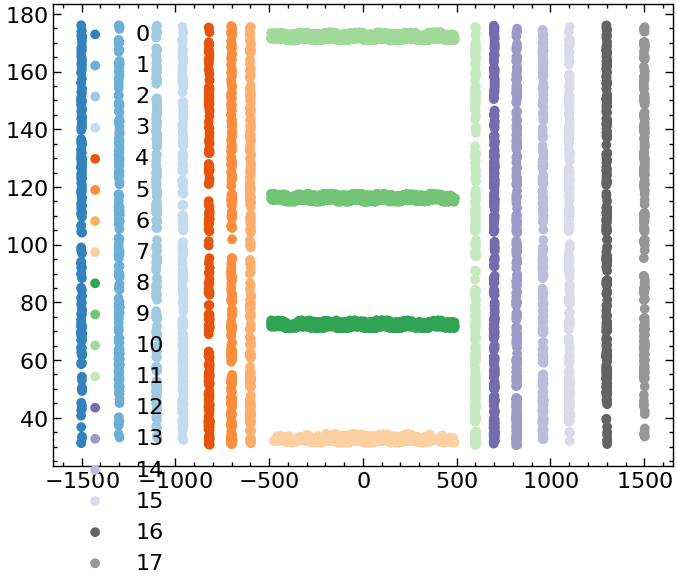

In [208]:
fig, ax = plt.subplots()
for layer in range(18):
    ax.scatter("z", "r", data=pcdf.query(f"layer == {layer}"), ls="", marker="o", label=layer, c=plt.cm.tab20c.colors[layer])
ax.legend()

In [177]:
pc.num_nodes

6873

In [178]:
df = gb.process(pc)

In [179]:
df.intersected.any()

True

In [180]:
len(df)

3543122

In [181]:
df["accepted"] = df["z0_mask"] & df["dR_mask"] & df["phi_slope_mask"]

In [214]:
dft = df.query("(layer2 == 11)")

In [210]:
dft

,index_1,index_2,dr,dphi,dz,dR,intersected,phi_slope_mask,z0_mask,dR_mask,layer1,layer2,r_1,r_2,z_1,z_2,accepted


index_1                  566
index_2                  784
dr                -29.868866
dphi               -0.046301
dz                     144.0
dR                  0.059442
intersected            False
phi_slope_mask          True
z0_mask                 True
dR_mask                 True
layer1                     3
layer2                     4
r_1               164.812119
r_2               134.943253
z_1                   -962.0
z_2                   -818.0
accepted                True
Name: 1347, dtype: object
-962.0
index_1                 569
index_2                 787
dr               -13.972153
dphi               0.005739
dz                    140.0
dR                 0.006039
intersected           False
phi_slope_mask         True
z0_mask                True
dR_mask                True
layer1                    3
layer2                    4
r_1               96.626976
r_2               82.654823
z_1                  -957.5
z_2                  -817.5
accepted               Tru

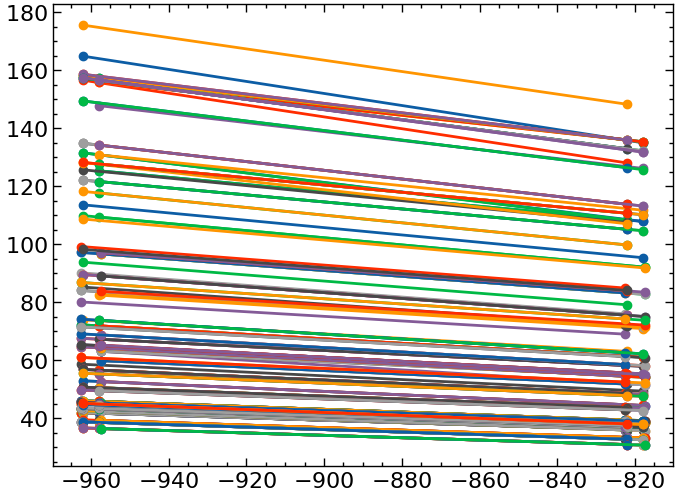

In [184]:
fig, ax = plt.subplots()
for _, row in dft.iterrows():
    print(row)
    print(row["z_1"])
    ax.plot((row.z_1, row.z_2), (row.r_1, row.r_2), marker="o")

In [147]:
sorted(np.unique(df.layer2.to_numpy()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]